# Eksplorasi Model Kontrol Game Subway Surfers Menggunakan MediaPipe & Klasifikasi Gestur Kepala

**Nama Kelompok:** 
- Geraldin Gysrawa [231511011]
- Ikhsan Zuhri Al Ghifary [231511015]
- Muhammad Harish Al-Rasyidi [231011020]

Tugas besar ini bertujuan untuk mengeksplorasi kapabilitas MediaPipe Face Mesh untuk aplikasi interaktif, yaitu sebagai kontroler game Subway Surfers. Proyek ini mencakup beberapa tahapan utama:
1.  **Pengumpulan Data:** Membuat dataset gestur kepala (Kiri, Kanan, Lompat, Menunduk, Netral) menggunakan aplikasi GUI sederhana.
2.  **Pelatihan Model:** Melatih model Machine Learning (SVM) untuk mengklasifikasikan gestur berdasarkan data pose kepala (yaw, pitch, roll) yang diekstrak oleh MediaPipe.
3.  **Evaluasi Model:** Menganalisis performa model menggunakan teknik cross-validation.
4.  **Implementasi Real-Time:** Mengintegrasikan model yang telah dilatih untuk mengontrol game secara langsung melalui input webcam.

## 1. Persiapan dan Setup Lingkungan

Langkah pertama adalah mengimpor semua library yang akan kita gunakan selama proses eksplorasi ini, mulai dari pemrosesan gambar (OpenCV), deteksi landmark (MediaPipe), hingga pelatihan model (Scikit-learn) dan kontrol keyboard (PyAutoGUI).

In [3]:
# Import library utama
import cv2
import mediapipe as mp
import numpy as np
import os
import json
import math
import time
import joblib
import pyautogui

# Import komponen dari Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import library untuk visualisasi (opsional tapi sangat direkomendasikan)
import matplotlib.pyplot as plt
import seaborn as sns

# Setup MediaPipe
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


## 2. Pengumpulan & Analisis Data

Untuk melatih model yang robust, kami tidak menggunakan *threshold* manual, melainkan membangun sebuah dataset khusus. Kami membuat aplikasi sederhana menggunakan Tkinter (`HeadGesture.py`) untuk merekam data pose kepala untuk setiap gestur yang diinginkan.

Aplikasi ini mengekstrak parameter **yaw, pitch, dan roll** dari MediaPipe Face Mesh dan menyimpannya dalam sebuah file JSON (`head_gestures.json`) bersama dengan label gesturnya.

Berikut adalah fungsi inti yang digunakan untuk mengekstrak fitur pose kepala dan memuat data dari file JSON.

In [6]:
# --- Kode dari HeadGesture.py & train_model.py ---

# Fungsi untuk menghitung yaw, pitch, roll dari landmark wajah
def calculate_head_pose(landmarks):
    # (Salin-tempel fungsi `calculate_head_pose` dari skrip Anda di sini)
    if not landmarks:
        return None
    nose_tip = landmarks[1]
    left_eye = landmarks[33]
    right_eye = landmarks[263]
    mouth_left = landmarks[61]
    mouth_right = landmarks[291]
    
    eye_center_x = (left_eye.x + right_eye.x) / 2
    nose_x = nose_tip.x
    yaw = (nose_x - eye_center_x) * 180
    
    eye_center_y = (left_eye.y + right_eye.y) / 2
    mouth_center_y = (mouth_left.y + mouth_right.y) / 2
    nose_y = nose_tip.y
    
    face_height = abs(eye_center_y - mouth_center_y)
    if face_height > 0:
        pitch = ((nose_y - eye_center_y) / face_height) * 60
    else:
        pitch = 0
        
    eye_slope = (right_eye.y - left_eye.y) / (right_eye.x - left_eye.x) if right_eye.x != left_eye.x else 0
    roll = math.atan(eye_slope) * 180 / math.pi
    
    return {'yaw': yaw, 'pitch': pitch, 'roll': roll}

# Fungsi untuk memuat data dari file JSON
def load_data(json_path='head_gestures/head_gestures.json'):
    # (Salin-tempel fungsi `load_data` dari skrip `train_model.py` Anda)
    with open(json_path, 'r') as f:
        gesture_db = json.load(f)
    X = []
    y = []
    for gesture in gesture_db:
        pose = gesture['head_pose']
        features = [pose['yaw'], pose['pitch'], pose['roll']]
        X.append(features)
        y.append(gesture['name'])
    return np.array(X), np.array(y)

# Memuat dan menampilkan informasi data
# Pastikan file 'head_gestures.json' ada di path yang benar
try:
    X_raw, y_raw = load_data()
    print(f"Data berhasil dimuat.")
    print(f"Jumlah sampel data: {len(X_raw)}")
    print(f"Bentuk matriks fitur (X): {X_raw.shape}")
    print(f"Bentuk vektor label (y): {y_raw.shape}")
    print(f"Kelas unik: {np.unique(y_raw)}")
except FileNotFoundError:
    print("Error: File 'head_gestures.json' tidak ditemukan. Pastikan Anda sudah mengumpulkan data.")

Data berhasil dimuat.
Jumlah sampel data: 450
Bentuk matriks fitur (X): (450, 3)
Bentuk vektor label (y): (450,)
Kelas unik: ['DUCK' 'JUMP' 'LEFT' 'NEUTRAL' 'RIGHT']


### 2.1. Visualisasi Distribusi Data Gestur

Langkah penting dalam analisis data adalah memahami distribusi kelas dalam dataset kita. Ini membantu kita untuk mengidentifikasi apakah dataset kita seimbang (*balanced*) atau tidak. Dataset yang tidak seimbang dapat menyebabkan model menjadi bias terhadap kelas mayoritas.

Kita akan menggunakan bar plot untuk menghitung jumlah sampel untuk setiap gestur.

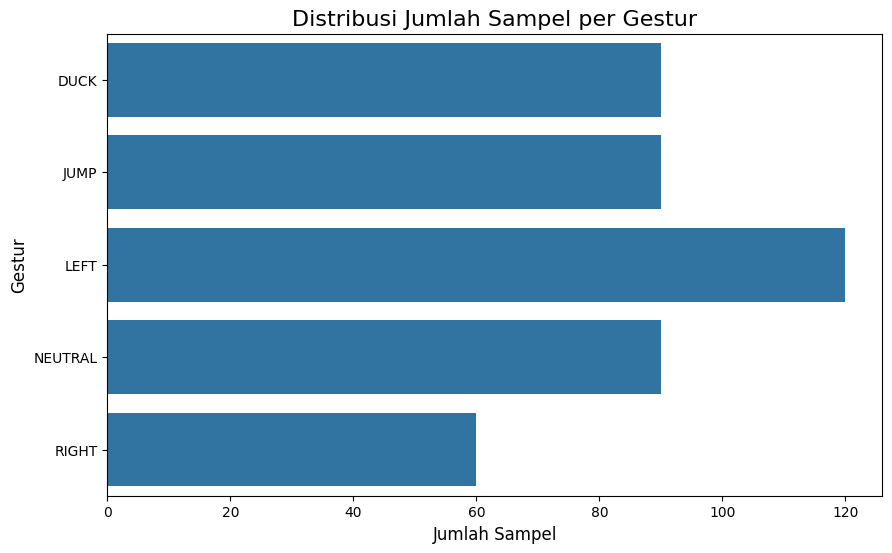

In [9]:
if 'y_raw' in locals():
    plt.figure(figsize=(10, 6))
    sns.countplot(y=y_raw, order=np.unique(y_raw))
    plt.title('Distribusi Jumlah Sampel per Gestur', fontsize=16)
    plt.xlabel('Jumlah Sampel', fontsize=12)
    plt.ylabel('Gestur', fontsize=12)
    plt.show()
else:
    print("Data belum dimuat, tidak dapat membuat visualisasi.")

## 3. Pelatihan & Evaluasi Model Klasifikasi

Setelah data siap, kami melatih model *Support Vector Machine* (SVM) untuk bertindak sebagai classifier. Fitur yang digunakan adalah (yaw, pitch, roll). Sebelum pelatihan, fitur-fitur ini distandarisasi menggunakan `StandardScaler` untuk memastikan skala yang seragam.

Untuk mendapatkan estimasi performa model yang andal, kami menggunakan validasi silang (5-fold cross-validation) dengan `StratifiedKFold` untuk menjaga proporsi kelas di setiap fold.

### 3.1. Pelatihan dengan Validasi Silang dan Analisis Performa

Selain metrik seperti akurasi, presisi, dan recall, kami juga akan memvisualisasikan **Confusion Matrix** untuk setiap *fold* dalam proses validasi silang. Confusion matrix memberikan gambaran visual yang jelas tentang kesalahan klasifikasi yang dibuat oleh model. Dari matriks ini, kita bisa melihat gestur mana yang sering tertukar satu sama lain.

Memulai 5-Fold Cross-Validation...

===== FOLD 1 =====
Akurasi: 1.0000
Laporan Klasifikasi:
              precision    recall  f1-score   support

        DUCK       1.00      1.00      1.00        18
        JUMP       1.00      1.00      1.00        18
        LEFT       1.00      1.00      1.00        24
     NEUTRAL       1.00      1.00      1.00        18
       RIGHT       1.00      1.00      1.00        12

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



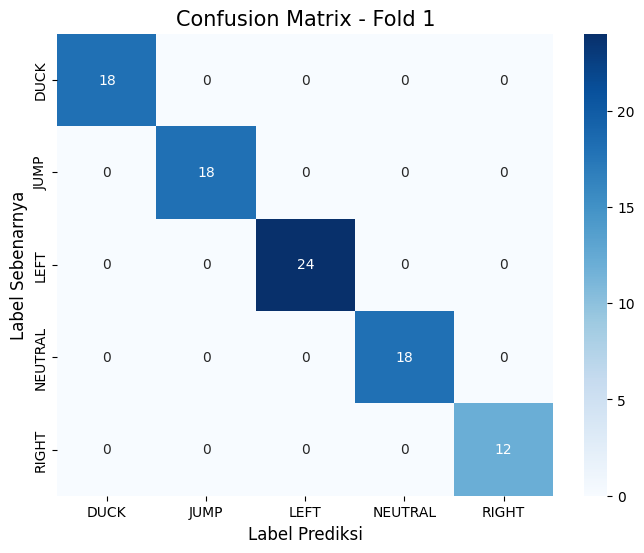

--------------------------------------------------

===== FOLD 2 =====
Akurasi: 1.0000
Laporan Klasifikasi:
              precision    recall  f1-score   support

        DUCK       1.00      1.00      1.00        18
        JUMP       1.00      1.00      1.00        18
        LEFT       1.00      1.00      1.00        24
     NEUTRAL       1.00      1.00      1.00        18
       RIGHT       1.00      1.00      1.00        12

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



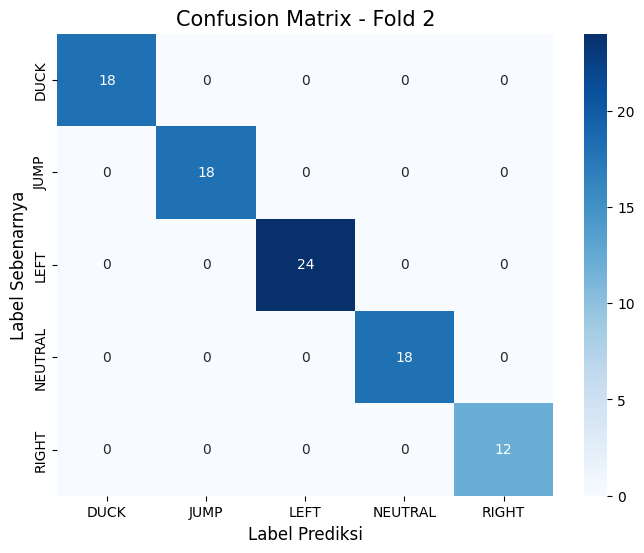

--------------------------------------------------

===== FOLD 3 =====
Akurasi: 1.0000
Laporan Klasifikasi:
              precision    recall  f1-score   support

        DUCK       1.00      1.00      1.00        18
        JUMP       1.00      1.00      1.00        18
        LEFT       1.00      1.00      1.00        24
     NEUTRAL       1.00      1.00      1.00        18
       RIGHT       1.00      1.00      1.00        12

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



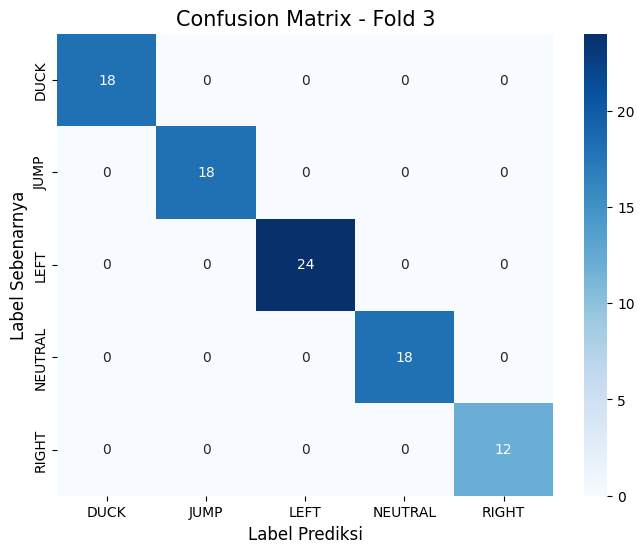

--------------------------------------------------

===== FOLD 4 =====
Akurasi: 1.0000
Laporan Klasifikasi:
              precision    recall  f1-score   support

        DUCK       1.00      1.00      1.00        18
        JUMP       1.00      1.00      1.00        18
        LEFT       1.00      1.00      1.00        24
     NEUTRAL       1.00      1.00      1.00        18
       RIGHT       1.00      1.00      1.00        12

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



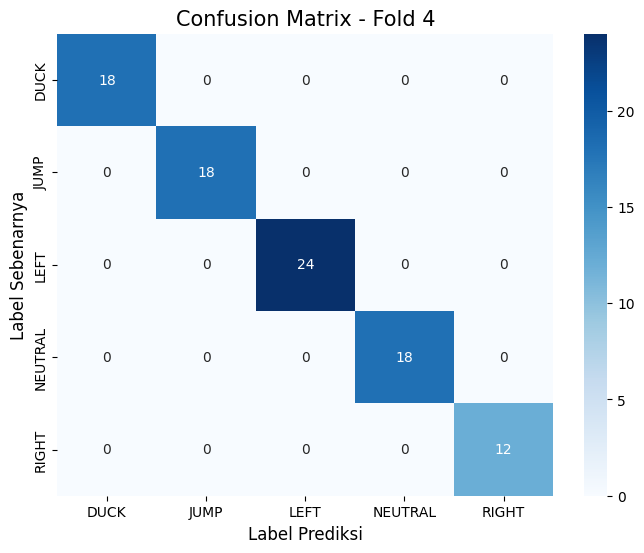

--------------------------------------------------

===== FOLD 5 =====
Akurasi: 1.0000
Laporan Klasifikasi:
              precision    recall  f1-score   support

        DUCK       1.00      1.00      1.00        18
        JUMP       1.00      1.00      1.00        18
        LEFT       1.00      1.00      1.00        24
     NEUTRAL       1.00      1.00      1.00        18
       RIGHT       1.00      1.00      1.00        12

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



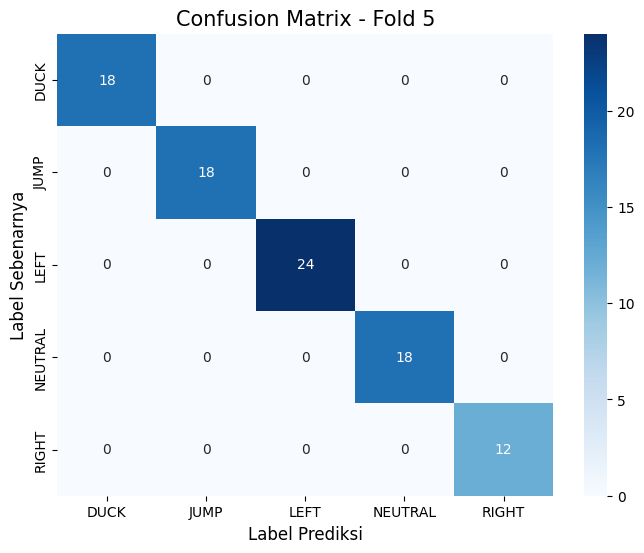

--------------------------------------------------


Evaluasi Selesai.
Akurasi Rata-rata dari 5 Fold: 1.0000 ± 0.0000

Melatih model final pada seluruh dataset...
Model final berhasil dilatih.
Model, scaler, dan encoder berhasil disimpan di folder 'models'.


In [10]:
# --- Kode dari train_model.py ---

if 'X_raw' in locals():
    # Standarisasi fitur
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    # Encode label
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_raw)

    # Cross-validation
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []

    print(f"Memulai {k}-Fold Cross-Validation...\n")
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y_encoded), 1):
        print(f"===== FOLD {fold} =====")
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model = SVC(kernel='rbf', probability=True, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)
        
        print(f"Akurasi: {acc:.4f}")
        print("Laporan Klasifikasi:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        
        # --- VISUALISASI CONFUSION MATRIX ---
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - Fold {fold}', fontsize=15)
        plt.ylabel('Label Sebenarnya', fontsize=12)
        plt.xlabel('Label Prediksi', fontsize=12)
        plt.show()
        # ------------------------------------
        
        print("-" * 50 + "\n")

    print(f"\nEvaluasi Selesai.")
    print(f"Akurasi Rata-rata dari {k} Fold: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

    # Latih ulang model final pada seluruh data
    print("\nMelatih model final pada seluruh dataset...")
    final_model = SVC(kernel='rbf', probability=True, random_state=42)
    final_model.fit(X_scaled, y_encoded)
    print("Model final berhasil dilatih.")

    # Simpan model, scaler, dan label encoder
    output_dir = 'models'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    joblib.dump(final_model, os.path.join(output_dir, 'gesture_svm.pkl'))
    joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
    joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.pkl'))
    print(f"Model, scaler, dan encoder berhasil disimpan di folder '{output_dir}'.")
else:
    print("Data belum dimuat. Jalankan sel sebelumnya terlebih dahulu.")

## 4. Implementasi Real-Time dan Kontrol Game

Ini adalah tahap akhir di mana kami menggabungkan semuanya. Kami akan memuat model yang telah dilatih dan menggunakannya untuk prediksi secara real-time dari input webcam. Hasil prediksi (nama gesture) kemudian dipetakan ke penekanan tombol keyboard virtual menggunakan `pyautogui` untuk mengontrol karakter dalam game Subway Surfers.

**Penting:** Untuk menjalankan sel di bawah ini:
1.  Pastikan game Subway Surfers sudah berjalan dan jendelanya **aktif (di-klik)**.
2.  Jalankan sel kode di bawah ini.
3.  Untuk menghentikan eksekusi, kembali ke notebook ini dan tekan tombol **"Interrupt the kernel"** (ikon kotak/stop) di toolbar Jupyter.

In [8]:
# --- Kode dari kontrol_subwaysurfer_gesture.py ---

# Muat model, scaler, dan label encoder yang sudah disimpan
try:
    model = joblib.load('models/gesture_svm.pkl')
    scaler = joblib.load('models/scaler.pkl')
    label_encoder = joblib.load('models/label_encoder.pkl')
    print("Model berhasil dimuat.")
except FileNotFoundError:
    print("Error: File model tidak ditemukan. Jalankan sel pelatihan terlebih dahulu.")
    model = None

if model:
    cap = cv2.VideoCapture(0)
    last_gesture = None
    last_time = time.time() # Untuk cooldown

    print("\nSIAP UNTUK MENGONTROL GAME!")
    print("Arahkan kursor ke jendela game dan tekan ESC di jendela video untuk keluar.")

    with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as face_mesh:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.flip(frame, 1)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_frame)
            
            gesture_text = "-"
            
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    pose = calculate_head_pose(face_landmarks.landmark)
                    if pose:
                        fitur = np.array([[pose['yaw'], pose['pitch'], pose['roll']]])
                        fitur_scaled = scaler.transform(fitur)
                        pred = model.predict(fitur_scaled)
                        gesture = label_encoder.inverse_transform(pred)[0]
                        gesture_text = gesture
                    
                    # Kontrol game dengan cooldown 0.5 detik
                    if gesture_text != last_gesture and gesture_text in ["JUMP", "LEFT", "RIGHT", "DUCK"]:
                        if time.time() - last_time > 0.5:
                            if gesture_text == "JUMP":
                                pyautogui.press('up')
                            elif gesture_text == "LEFT":
                                pyautogui.press('left')
                            elif gesture_text == "RIGHT":
                                pyautogui.press('right')
                            elif gesture_text == "DUCK":
                                pyautogui.press('down')
                            
                            print(f"Aksi: {gesture_text}")
                            last_gesture = gesture_text
                            last_time = time.time()
                    
                    elif gesture_text == "NEUTRAL":
                        last_gesture = None

            # Tampilkan hasil prediksi di frame
            cv2.putText(frame, f"Gesture: {gesture_text}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Kontrol Subway Surfers - Tekan ESC untuk Keluar', frame)
            
            if cv2.waitKey(5) & 0xFF == 27:
                break

    cap.release()
    cv2.destroyAllWindows()
    print("Kontrol dihentikan.")

Model berhasil dimuat.

SIAP UNTUK MENGONTROL GAME!
Arahkan kursor ke jendela game dan tekan ESC di jendela video untuk keluar.
Aksi: JUMP
Aksi: LEFT
Aksi: RIGHT
Aksi: DUCK
Aksi: JUMP
Aksi: RIGHT
Aksi: LEFT
Aksi: DUCK
Kontrol dihentikan.
